### Instructions

#### Given the data file "WorkOders15_18 Corrective.csv ":
- Recode label data
- Determine which factors influence MTTF (mean time to failure)
- Determine 20/80 for equipment failures (type, manufacturer, etc)
- Show descriptive statistics for MTTF and repair times
- Using machine learning predict extreme repair events (too soon, too long to repair, too costly)

#### Methodology:
- Carry out PCA. Summarize findings looking for relationship for variables time between failures (MTTF), repair time, cost
- Give statistics about time between failures (MTTF), repair time, cost (Including histograms)
- Do some math to find 20/80's of those variables
- Create classes and carry out machine learning to determine what causes those rather extreme cases
    
#### Deliver:
- Statistical analysis (mean, std dev, max, min, etc.) for time between failures (MTTF), repair time, cost
- Principal component analysis answering what variables influence time between failures (MTTF), repair time, cost
- Machine learning to predict time between failures (MTTF), repair time, cost after having established some thresholds. - There are suggestions but please set your own thresholds:
    
    ##### Duration
The threshold was 7 days for all jobs, which is 95% percentile and 6 days for corrective jobs, which is also 95% percentile. 
A Duration of less than the threshold is label as 0. A duration above the threshold was labelled as 1 
    ##### Total cost
The threshold was established at $6520.00 which is 99% percentile (above is 1, below is 0) and $6700.00 for corrective jobs (99% percentile)
    ##### Time between reports
For the same equipment the threshold was set to 40 days for both general and corrective reports 63% percentile general, 42% corrective, above is 0, below is 1

In [ ]:
!pip install catboost

     |████████████████████████████████| 76.3 MB 1.3 MB/s 


In [ ]:
# -----------------------------------------------------------------------------------------------------------------
# Import libraries
# -----------------------------------------------------------------------------------------------------------------
import pandas as pd
import numpy as np
from sklearn import preprocessing
import catboost
from catboost import CatBoostClassifier, Pool, cv
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from scipy import stats
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import seaborn as sns
from google.colab import files
import io
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter


from numpy import sqrt
from numpy import array
from numpy import mean
from numpy import std
from numpy import zeros
from numpy import around
from numpy import set_printoptions

set_printoptions(precision=6,suppress=True)
from sklearn.decomposition import PCA

FieldProductionTeam,

EquipmentType,

EquipmentClass,

EquipmentCriticality,

Priority, 

Cause,

FailureReason,

Duration, 

GrossProductionLoss,

AffectedProduction,

IsAffectingProduction,

TotalCost,

Manufacturer,

ActualDuration, 

TBF,

TBF_Equipment




In [ ]:
# -----------------------------------------------------------------------------------------------------------------
# Open the dataset
# -----------------------------------------------------------------------------------------------------------------
uploaded = files.upload()
dataset = pd.read_csv(io.BytesIO(uploaded['WorkOders15_18 Corrective (1).csv']))

Saving WorkOders15_18 Corrective (1).csv to WorkOders15_18 Corrective (1).csv


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (13) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# -----------------------------------------------------------------------------------------------------------------
# Save the dataset as .xlsx
# -----------------------------------------------------------------------------------------------------------------
#dataset.to_excel(r'C:\Users\Manuel Wereb\Dropbox\Studium\Semester\TEC de Monterrey\Data Science and Big Data Analytics\Classworks\WorkOders15_18 Corrective_10Lines.xlsx')

In [ ]:
# -----------------------------------------------------------------------------------------------------------------
# Drop columns which contain always the same value or always a different value to reduce the size of the dataset
# -----------------------------------------------------------------------------------------------------------------
datasetFiltered = pd.DataFrame(data=None, columns=None)
for column in dataset.columns:
    print('{0} has {1} rows and {2} different values'.format(column, len(dataset.index), len(dataset[column].unique())))
    if len(dataset[column].unique()) != 1 and len(dataset[column].unique()) != len(dataset.index):
        datasetFiltered[column] = dataset[column]
    else:
        print('--> {0} is dropped'.format(column))

In [ ]:
# -----------------------------------------------------------------------------------------------------------------    
# Drop the column StatusDescription and StatusShortDescription because it contains exact the same statement as StatusCode
# -----------------------------------------------------------------------------------------------------------------    
datasetFiltered['StatusDescription'] = datasetFiltered['StatusDescription'].replace(['C - Closed - Sent to History', 'D - Waiting Work Order Completion'], ['C', 'D'])
comparisonColumn = np.where(datasetFiltered['StatusCode'] == datasetFiltered['StatusDescription'], True, False)
if False not in comparisonColumn:
    datasetFiltered = datasetFiltered.drop('StatusDescription', axis=1)
    
datasetFiltered['StatusShortDescription'] = datasetFiltered['StatusShortDescription'].replace(['Closed(C)', 'Complete(D)'], ['C', 'D'])
comparisonColumn = np.where(datasetFiltered['StatusCode'] == datasetFiltered['StatusShortDescription'], True, False)
if False not in comparisonColumn:
    datasetFiltered = datasetFiltered.drop('StatusShortDescription', axis=1)

In [ ]:
# -----------------------------------------------------------------------------------------------------------------    
# Count different values in the columns of the dataset
# -----------------------------------------------------------------------------------------------------------------    
datasetFiltered['Priority'] = datasetFiltered['Priority'].replace([1, 2, 3, 4, 5], ['1', '2', '3', '4', '5'])
for column in datasetFiltered.columns:
    print(datasetFiltered[column].value_counts())
    print('\n')

In [ ]:
# -----------------------------------------------------------------------------------------------------------------    
# Drop non-informative columns to reduce the size of the dataset
# -----------------------------------------------------------------------------------------------------------------    
datasetFiltered = datasetFiltered.drop(['Comment', 'EquipmentCode', 'EquipmentRollupCode', 'EquipmentDescription', 'StatusCode', 'Action', 'Requirement', 'LaborCost', 'MaterialCost', 'Assigned', 'Trade', 'TradeGroup', 'SupervisorRole', 'Model', 'Safety', 'Reopened',  'CreatedBy', 'UpdatedBy', 'CreatedDate', 'UpdatedDate', 'ReportDate', 'ReportMonth', 'ReportWeekDay', 'TargetDate', 'SchEndDate', 'ScheduleCompliant',  'CompletedDate', 'CompletedMonth', 'CompletedWeekDay'], axis=1)
datasetFiltered                                        

,FieldProductionTeam,EquipmentType,EquipmentClass,EquipmentCriticality,Priority,Cause,FailureReason,Duration,GrossProductionLoss,AffectedProduction,IsAffectingProduction,TotalCost,Manufacturer,ActualDuration,TBF,TBF_Equipment
0,RANGELY,System,SE - Battery,NA - Not Applicable,2,Plugged,Pipe - Piping,1,0,0,No,1700,NOTAPPLICABLE,-1,0,4.0
1,VAN,System,Line - Production Flowline,3 - Low,4,Missing,"Assembly - Pump, Chemical",1,0,0,No,700,NOTAPPLICABLE,3,0,NaN
2,VAN,Asset,Pumping Unit,3 - Low,3,Loose,Component - Belt,1,0,4,Yes,300,LUFKIN,19,0,1.0
3,VAN,System,SE - Field,NA - Not Applicable,3,Improper Fit,Pipe - Piping,1,0,0,No,457,NOTAPPLICABLE,19,0,0.0
4,VAN,System,SE - Field,NA - Not Applicable,3,Fouling,"Pump, other",1,0,0,No,483,NOTAPPLICABLE,19,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89475,KR,Position,Pump - Centrifugal Single Stage,3 - Low,3,Flow Cut / Erosion / Wear,"Component - Rings, Carbon",1,0,0,No,0,GOULDSPUMPS,0,0,NaN
89476,TAH,Position,Motor - AC Induction,R2 - Moderate,4,Dirty,Component - Filter,1,0,0,No,845,ELECTRICMACHINE,0,0,NaN
89477,VEALMOOR,Asset,Pumping Unit,R3 - Low,3,Broken,"End Device - Switch, Pressure",1,25,3,Yes,917,LUFKIN,0,0,NaN
89478,CY,Position,Vessel - Dehydrator,3 - Low,2,Out of Calibration,Wiring,1,0,0,No,0,None,0,0,NaN


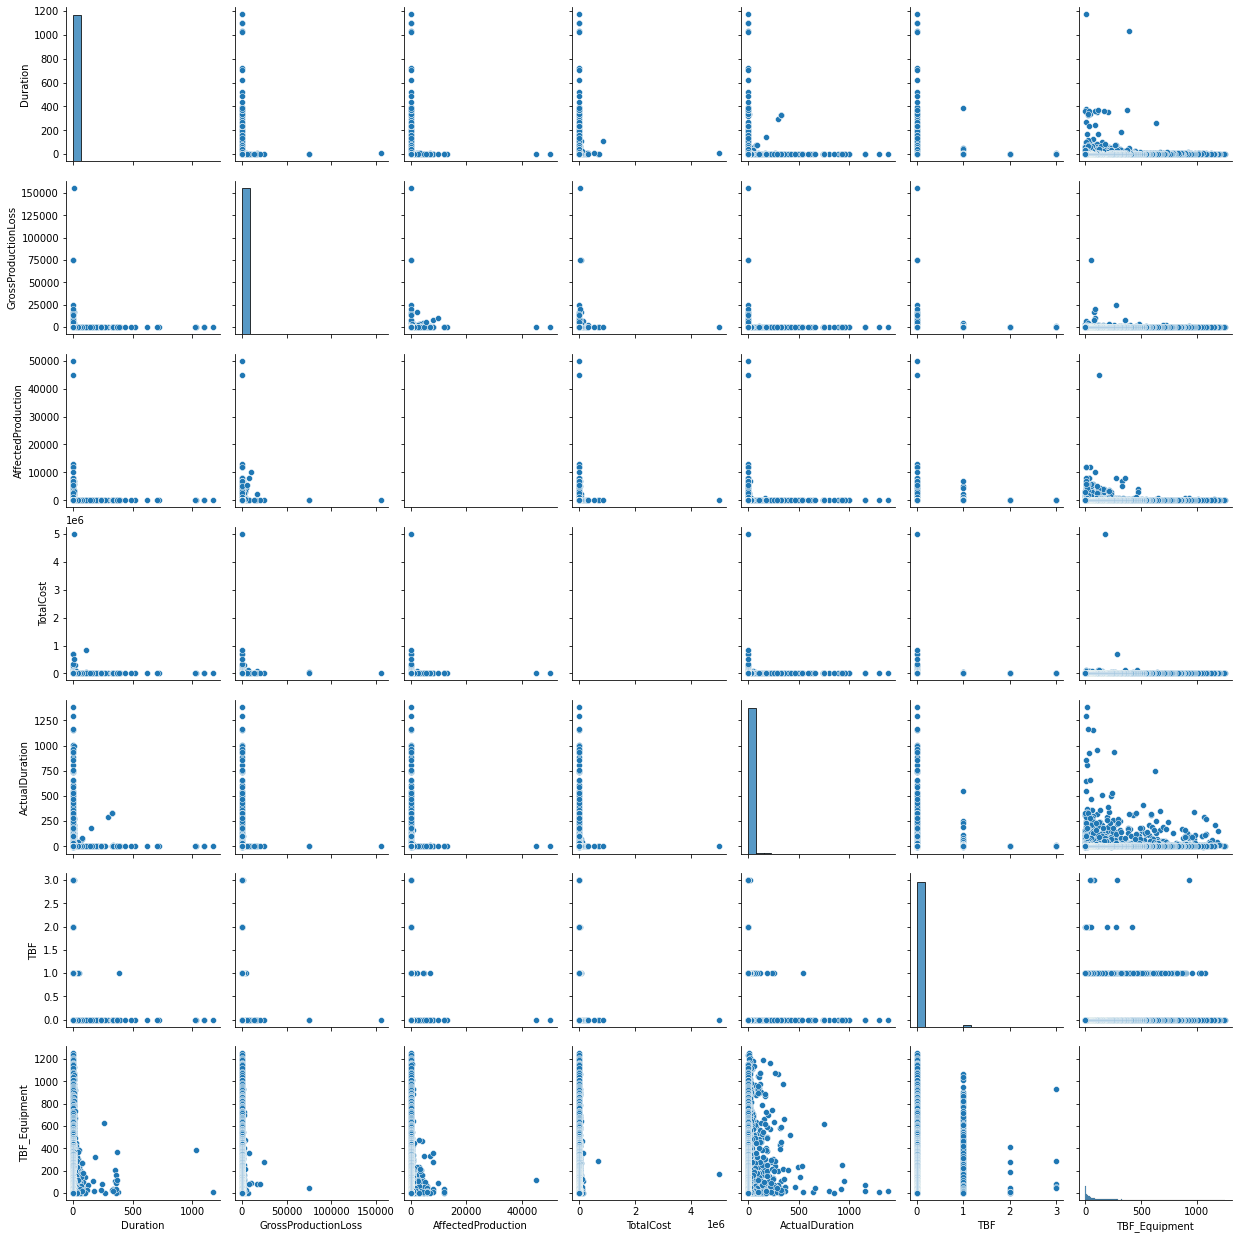

In [ ]:
sns.pairplot(data = datasetFiltered, dropna = True)

In [ ]:
# -----------------------------------------------------------------------------------------------------------------    
# Encode non-numerical columns to numerical
# -----------------------------------------------------------------------------------------------------------------    
datasetEncode = pd.DataFrame(data=None, columns=datasetFiltered.columns)
label_encoder = preprocessing.LabelEncoder()
numericalColumns = datasetEncode._get_numeric_data().columns

for column in datasetFiltered.columns:
    if column not in numericalColumns:
        datasetEncode[column] = label_encoder.fit_transform(datasetFiltered[column])
print(datasetEncode)

       FieldProductionTeam  EquipmentType  ...  TBF  TBF_Equipment
0                       41              3  ...    0              4
1                       50              3  ...    0           1020
2                       50              0  ...    0              1
3                       50              3  ...    0              0
4                       50              3  ...    0              0
...                    ...            ...  ...  ...            ...
89475                   25              2  ...    0           1020
89476                   48              2  ...    0           1020
89477                   51              0  ...    0           1020
89478                   13              2  ...    0           1020
89479                   48              2  ...    0           1020

[89480 rows x 16 columns]


In [ ]:
datasetFiltered.describe()

,Duration,GrossProductionLoss,AffectedProduction,TotalCost,ActualDuration,TBF,TBF_Equipment
count,89480.000000,89480.000000,89480.000000,8.948000e+04,89480.000000,89480.000000,43698.000000
mean,1.979001,15.377347,17.170586,7.245155e+02,1.495451,0.014126,124.043297
std,12.657583,661.908685,292.325789,1.767736e+04,20.174754,0.121373,168.194937
min,1.000000,0.000000,0.000000,0.000000e+00,-4.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,14.000000
50%,1.000000,0.000000,0.000000,2.330000e+02,0.000000,0.000000,56.000000
75%,1.000000,0.000000,5.000000,6.022500e+02,0.000000,0.000000,168.000000
max,1171.000000,156000.000000,50000.000000,5.010670e+06,1384.000000,3.000000,1253.000000


In [ ]:
dfmean=datasetFiltered[["TotalCost","ActualDuration","TBF"]].mean()
print(dfmean)

TotalCost         724.515512
ActualDuration      1.495451
TBF                 0.014126
dtype: float64


In [ ]:
dfstd=datasetFiltered[["TotalCost","ActualDuration","TBF"]].std()
print(dfstd)

TotalCost         17677.358268
ActualDuration       20.174754
TBF                   0.121373
dtype: float64


In [ ]:
dfmin=datasetFiltered[["TotalCost","ActualDuration","TBF"]].min()
print(dfmin)

TotalCost         0
ActualDuration   -4
TBF               0
dtype: int64


In [ ]:
dfmax=datasetFiltered[["TotalCost","ActualDuration","TBF"]].max()
print(dfmax)

TotalCost         5010670
ActualDuration       1384
TBF                     3
dtype: int64


# HISTOGRAMS

In [ ]:
plt.hist(datasetEncode['TotalCost'], color="yellow", ec="black")


In [ ]:
plt.hist(datasetEncode['TBF'], color="yellow", ec="black")
plt.xlim(xmin=0, xmax = 1.75)

In [ ]:
plt.hist(datasetEncode['Duration'], color="yellow", ec="black")
plt.xlim(xmin=0.0, xmax = 60)

# PARETO DIAGRAMS

In [ ]:
frecET = pd.value_counts(datasetFiltered['EquipmentType'])
frecET

In [ ]:
frec_ET=pd.DataFrame(frecET)

frec_ET.columns=["Frec_abs"]

frec_ET

In [ ]:
frec_ET["Frec_rel_%"]=100*frec_ET["Frec_abs"]/len(datasetFiltered)

Frec_rel_val = frec_ET["Frec_rel_%"].values

acum =[]

valor_acum = 0

for i in Frec_rel_val:
    valor_acum = valor_acum + i
    acum.append(valor_acum)
    
frec_ET["Frec_rel_%_acum"] = acum
frec_ET

fig = plt.figure()
ax = fig.add_subplot (1,1,1)

ax.set_title('Equipment Type Diagram')

ax.bar(frec_ET.index, frec_ET["Frec_abs"], color="C0")

ax2 = ax.twinx() 
ax2.plot(frec_ET.index, frec_ET["Frec_rel_%_acum"], color="C1", marker="D", ms=5)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")

ax.set_xticklabels(frec_ET.index,rotation=75)

In [ ]:
frecC = pd.value_counts(datasetFiltered['Cause'])

frec_C=pd.DataFrame(frecC)

frec_C.columns=["Frec_abs"]

In [ ]:
frec_C["Frec_rel_%"]=100*frec_C["Frec_abs"]/len(datasetFiltered)

Frec_rel_val = frec_C["Frec_rel_%"].values

acum =[]

valor_acum = 0

for i in Frec_rel_val:
    valor_acum = valor_acum + i
    acum.append(valor_acum)
    
frec_C["Frec_rel_%_acum"] = acum

fig = plt.figure()
ax = fig.add_subplot (1,1,1)

ax.set_title('Cause Diagram')

ax.bar(frec_C.index, frec_C["Frec_abs"], color="C0")

ax2 = ax.twinx() 
ax2.plot(frec_C.index, frec_C["Frec_rel_%_acum"], color="C1", marker="D", ms=5)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")

ax.set_xticklabels(frec_C.index,rotation=75)

In [ ]:
frecEC = pd.value_counts(datasetFiltered['EquipmentClass'])


frec_EC=pd.DataFrame(frecEC)

frec_EC.columns=["Frec_abs"]


In [ ]:
frec_EC["Frec_rel_%"]=100*frec_EC["Frec_abs"]/len(datasetFiltered)

Frec_rel_val = frec_EC["Frec_rel_%"].values

acum =[]

valor_acum = 0

for i in Frec_rel_val:
    valor_acum = valor_acum + i
    acum.append(valor_acum)
    
frec_EC["Frec_rel_%_acum"] = acum

fig = plt.figure()
ax = fig.add_subplot (1,1,1)

ax.set_title('Equipment Class Diagram')

ax.bar(frec_EC.index, frec_EC["Frec_abs"], color="C0")

ax2 = ax.twinx() 
ax2.plot(frec_EC.index, frec_EC["Frec_rel_%_acum"], color="C1", marker="D", ms=5)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")

ax.set_xticklabels(frec_EC.index,rotation=75)

In [ ]:
frecMF = pd.value_counts(datasetFiltered['Manufacturer'])


frec_MF=pd.DataFrame(frecMF)

frec_MF.columns=["Frec_abs"]

In [ ]:
frec_MF["Frec_rel_%"]=100*frec_MF["Frec_abs"]/len(datasetFiltered)

Frec_rel_val = frec_MF["Frec_rel_%"].values

acum =[]

valor_acum = 0

for i in Frec_rel_val:
    valor_acum = valor_acum + i
    acum.append(valor_acum)
    
frec_MF["Frec_rel_%_acum"] = acum

fig = plt.figure()
ax = fig.add_subplot (1,1,1)

ax.set_title('Manufacturer Diagram')

ax.bar(frec_MF.index, frec_MF["Frec_abs"], color="C0")

ax2 = ax.twinx() 
ax2.plot(frec_D.index, frec_D["Frec_rel_%_acum"], color="C1", marker="D", ms=5)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")

ax.set_xticklabels(frec_MF.index,rotation=75)

In [ ]:
frecD = pd.value_counts(datasetEncode['Duration'])


frec_D=pd.DataFrame(frecD)

frec_D.columns=["Frec_abs"]

In [ ]:
frec_D["Frec_rel_%"]=100*frec_D["Frec_abs"]/len(datasetEncode)

Frec_rel_val = frec_D["Frec_rel_%"].values

acum =[]

valor_acum = 0

for i in Frec_rel_val:
    valor_acum = valor_acum + i
    acum.append(valor_acum)
    
frec_D["Frec_rel_%_acum"] = acum

fig = plt.figure()
ax = fig.add_subplot (1,1,1)

ax.set_title('DURATION Diagram')

ax.bar(frec_D.index, frec_D["Frec_abs"], color="C0")

ax2 = ax.twinx() 
ax2.plot(frec_D.index, frec_D["Frec_rel_%_acum"], color="C1", marker="D", ms=5)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")

ax.set_xticklabels(frec_D.index,rotation=75)

In [ ]:
frecTBF = pd.value_counts(datasetEncode['TBF'])


frec_TBF=pd.DataFrame(frecTBF)

frec_TBF.columns=["Frec_abs"]

In [ ]:
frec_TBF["Frec_rel_%"]=100*frec_TBF["Frec_abs"]/len(datasetEncode)

Frec_rel_val = frec_TBF["Frec_rel_%"].values

acum =[]

valor_acum = 0

for i in Frec_rel_val:
    valor_acum = valor_acum + i
    acum.append(valor_acum)
    
frec_TBF["Frec_rel_%_acum"] = acum

fig = plt.figure()
ax = fig.add_subplot (1,1,1)

ax.set_title('TBF Diagram')

ax.bar(frec_TBF.index, frec_TBF["Frec_abs"], color="C0")

ax2 = ax.twinx() 
ax2.plot(frec_TBF.index, frec_TBF["Frec_rel_%_acum"], color="C1", marker="D", ms=5)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")

ax.set_xticklabels(frec_TBF.index,rotation=75)

In [ ]:
frecTC= pd.value_counts(datasetEncode['TotalCost'])


frec_TC=pd.DataFrame(frecTC)

frec_TC.columns=["Frec_abs"]


In [ ]:
frec_TC["Frec_rel_%"]=100*frec_TC["Frec_abs"]/len(datasetEncode)

Frec_rel_val = frec_TC["Frec_rel_%"].values

acum =[]

valor_acum = 0

for i in Frec_rel_val:
    valor_acum = valor_acum + i
    acum.append(valor_acum)
    
frec_TC["Frec_rel_%_acum"] = acum

fig = plt.figure()
ax = fig.add_subplot (1,1,1)

ax.set_title('TOTAL COST Diagram')

ax.bar(frec_TC.index, frec_TC["Frec_abs"], color="C0")

ax2 = ax.twinx() 
ax2.plot(frec_TC.index, frec_TC["Frec_rel_%_acum"], color="C1", marker="D", ms=5)
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")

ax.set_xticklabels(frec_TC.index,rotation=75)

# PCA

In [ ]:
df_PCA=datasetFiltered
df_PCA.head()

,FieldProductionTeam,EquipmentType,EquipmentClass,EquipmentCriticality,Priority,Cause,FailureReason,Duration,GrossProductionLoss,AffectedProduction,IsAffectingProduction,TotalCost,Manufacturer,ActualDuration,TBF,TBF_Equipment,cumulative_sum,cumulative_perc
0,RANGELY,System,SE - Battery,NA - Not Applicable,2,Plugged,Pipe - Piping,1,0,0,No,1700,NOTAPPLICABLE,-1,0,4.0,0,0.0
1,VAN,System,Line - Production Flowline,3 - Low,4,Missing,"Assembly - Pump, Chemical",1,0,0,No,700,NOTAPPLICABLE,3,0,NaN,0,0.0
2,VAN,Asset,Pumping Unit,3 - Low,3,Loose,Component - Belt,1,0,4,Yes,300,LUFKIN,19,0,1.0,0,0.0
3,VAN,System,SE - Field,NA - Not Applicable,3,Improper Fit,Pipe - Piping,1,0,0,No,457,NOTAPPLICABLE,19,0,0.0,0,0.0
4,VAN,System,SE - Field,NA - Not Applicable,3,Fouling,"Pump, other",1,0,0,No,483,NOTAPPLICABLE,19,0,0.0,0,0.0


In [ ]:
df_PCA.dtypes

FieldProductionTeam       object
EquipmentType             object
EquipmentClass            object
EquipmentCriticality      object
Priority                  object
Cause                     object
FailureReason             object
Duration                   int64
GrossProductionLoss        int64
AffectedProduction         int64
IsAffectingProduction     object
TotalCost                  int64
Manufacturer              object
ActualDuration             int64
TBF                        int64
TBF_Equipment            float64
cumulative_sum             int64
cumulative_perc          float64
dtype: object

In [ ]:
#encoding FieldProductionTeam
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df_PCA['FieldProductionTeam'] = label_encoder.fit_transform(df_PCA['FieldProductionTeam'])

#encoding EquipmentType
label_encoder = preprocessing.LabelEncoder()
df_PCA['EquipmentType'] = label_encoder.fit_transform(df_PCA['EquipmentType'])

label_encoder = preprocessing.LabelEncoder()
df_PCA['EquipmentClass'] = label_encoder.fit_transform(df_PCA['EquipmentClass'])

label_encoder = preprocessing.LabelEncoder()
df_PCA['EquipmentCriticality'] = label_encoder.fit_transform(df_PCA['EquipmentCriticality'])

label_encoder = preprocessing.LabelEncoder()
df_PCA['Priority'] = label_encoder.fit_transform(df_PCA['Priority'])

label_encoder = preprocessing.LabelEncoder()
df_PCA['Cause'] = label_encoder.fit_transform(df_PCA['Cause'])

label_encoder = preprocessing.LabelEncoder()
df_PCA['FailureReason'] = label_encoder.fit_transform(df_PCA['FailureReason'])

label_encoder = preprocessing.LabelEncoder()
df_PCA['IsAffectingProduction'] = label_encoder.fit_transform(df_PCA['IsAffectingProduction'])

label_encoder = preprocessing.LabelEncoder()
df_PCA['Manufacturer'] = label_encoder.fit_transform(df_PCA['Manufacturer'])

df_PCA.dtypes

FieldProductionTeam        int64
EquipmentType              int64
EquipmentClass             int64
EquipmentCriticality       int64
Priority                   int64
Cause                      int64
FailureReason              int64
Duration                   int64
GrossProductionLoss        int64
AffectedProduction         int64
IsAffectingProduction      int64
TotalCost                  int64
Manufacturer               int64
ActualDuration             int64
TBF                        int64
TBF_Equipment            float64
cumulative_sum             int64
cumulative_perc          float64
dtype: object

In [ ]:
df_PCA=df_PCA.fillna(0)

In [ ]:
header_row = df_PCA.columns.values
M = mean(df_PCA.T, axis=1)

In [ ]:
print(header_row)

['FieldProductionTeam' 'EquipmentType' 'EquipmentClass'
 'EquipmentCriticality' 'Priority' 'Cause' 'FailureReason' 'Duration'
 'GrossProductionLoss' 'AffectedProduction' 'IsAffectingProduction'
 'TotalCost' 'Manufacturer' 'ActualDuration' 'TBF' 'TBF_Equipment'
 'cumulative_sum' 'cumulative_perc']


In [ ]:
st = std(df_PCA.T, axis=1,ddof=1)
# Normalize data
Xdat = (df_PCA - M)/st
Xdat.head()

,FieldProductionTeam,EquipmentType,EquipmentClass,EquipmentCriticality,Priority,Cause,FailureReason,Duration,GrossProductionLoss,AffectedProduction,IsAffectingProduction,TotalCost,Manufacturer,ActualDuration,TBF,TBF_Equipment,cumulative_sum,cumulative_perc
0,1.280775,1.185315,0.096260,0.227075,-1.627663,1.637864,0.810253,-0.077345,-0.023232,-0.058738,-0.791828,0.055183,0.403404,-0.123692,-0.116386,-0.425744,-2.294394,-2.294394
1,1.974998,1.185315,-1.001867,-0.769548,1.579986,0.717628,-1.651625,-0.077345,-0.023232,-0.058738,-0.791828,-0.001387,0.403404,0.074576,-0.116386,-0.455844,-2.294394,-2.294394
2,1.974998,-1.726849,0.010692,-0.769548,-0.023839,0.550313,-1.267305,-0.077345,-0.023232,-0.045054,1.262887,-0.024015,-0.047220,0.867646,-0.116386,-0.448319,-2.294394,-2.294394
3,1.974998,1.185315,0.139044,0.227075,-0.023839,0.215682,0.810253,-0.077345,-0.023232,-0.058738,-0.791828,-0.015133,0.403404,0.867646,-0.116386,-0.455844,-2.294394,-2.294394
4,1.974998,1.185315,0.139044,0.227075,-0.023839,-0.286265,0.916080,-0.077345,-0.023232,-0.058738,-0.791828,-0.013662,0.403404,0.867646,-0.116386,-0.455844,-2.294394,-2.294394


In [ ]:
# create the PCA instance
pca = PCA()
# fit on data
pcafit=pca.fit(Xdat)
#Q eigenvectors
Q=pca.components_.T
#Explained deviations
s=sqrt(pca.explained_variance_)
# transform data obtain sample scores
F = pca.transform(Xdat)
print("Sample scores")
print(F)
# Obtain Factor Loadings
L = zeros(shape=(Q.shape))
for col in range(0,len(s)-1):
    L[:,col] = Q[:,col] * s[col]
print("Factor Loadings")
print(L)
#Obtain squared cosines
COS2=L**2
print("Square Cosines")
print(COS2)
print("Interpret the COS2 results")

In [ ]:
print(COS2.shape)

(18, 18)


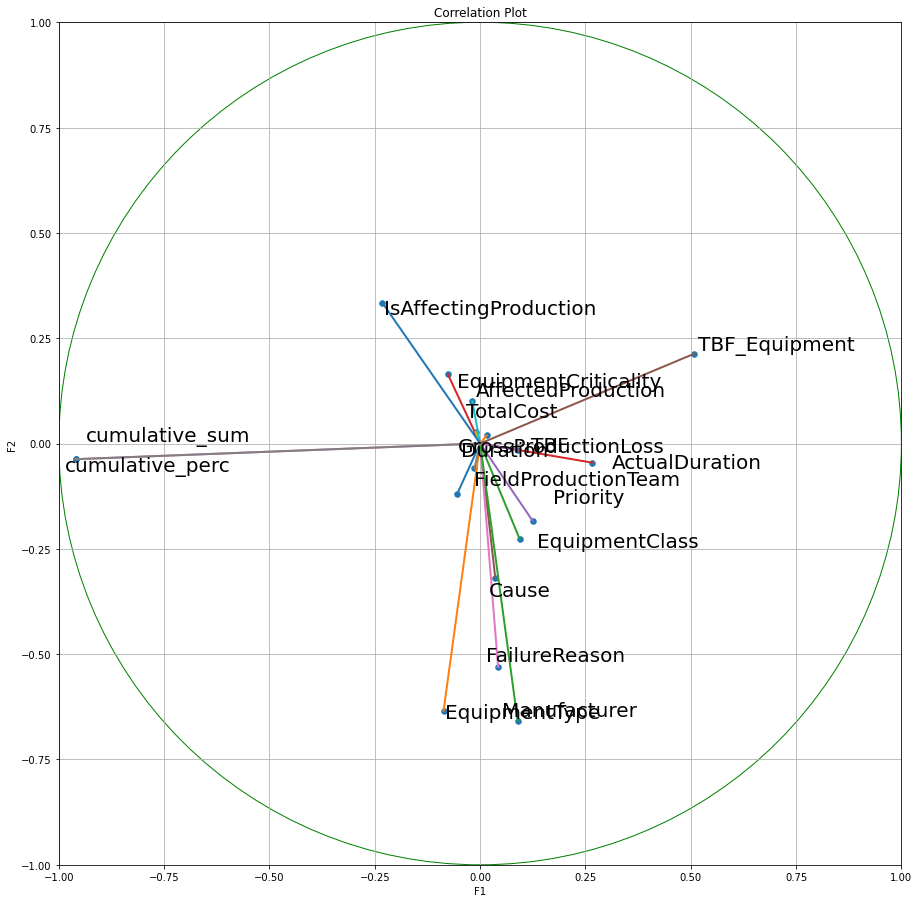

In [ ]:
import matplotlib.pyplot as plt
import random

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.grid()
plt.axis([-1,1,-1,1])
circ=plt.Circle((0,0), radius=1, color='g', fill=False)
ax.add_patch(circ)
ax.set_aspect('equal')
plt.scatter(L[:,0],L[:,1],s=30)
#plt.scatter(F[:,0],F[:,1],s=30)


for row in range(0,len(s)):
    plt.plot([0, L[row,0]], [0,L[row,1]], linewidth=2,label='X1')

for row in range(0,len(s)):
    #ax.annotate('X'+str(row+1), (L[row,0]+0.01,L[row,1]+0.01))
    ax.annotate(header_row[row], (L[row,0]+random.uniform(-0.05,0.05),L[row,1]+random.uniform(-0.05,0.05)),size=20)

plt.ylabel('F2')
plt.xlabel('F1')
plt.title('Correlation Plot')
fig.set_size_inches(24.5, 15.5)
fig.savefig('PCA_Correlation_Plot.jpg', dpi=300)
plt.show()

In [ ]:
#here we can see a plot with the loadings of our variables on the first two principal components. The variables of interest TotalCost, Actual Duration and TBF don't have very strong impact by any other
#variable (they generally score low on the first two PC) but we can still establish weaker links. Actual duration is impacted by cumulative_sum and cumulative_perc (these are variables we introduced
# earlier). Moreover, TBF_Equipment is also impacted by the two cumulative variables.
#

In [ ]:
from astropy.table import Table
from numpy import c_
t = Table(c_[header_row,COS2[:,0:18]], names=['Var','F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13','F14','F15','F16','F17','F18'],
          dtype=('S10','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8','f8'))

t['F1'].info.format = '7.6f'
t['F2'].info.format = '7.6f'
t['F3'].info.format = '7.6f'
t['F4'].info.format = '7.6f'
t['F5'].info.format = '7.6f'
t['F6'].info.format = '7.6f'
t['F7'].info.format = '7.6f'
t['F8'].info.format = '7.6f'
t['F9'].info.format = '7.6f'
t['F10'].info.format = '7.6f'
t['F11'].info.format = '7.6f'
t['F12'].info.format = '7.6f'
t['F13'].info.format = '7.6f'
t['F14'].info.format = '7.6f'
t['F15'].info.format = '7.6f'
t['F16'].info.format = '7.6f'
t['F17'].info.format = '7.6f'
t['F18'].info.format = '7.6f'
t['F1','F2','F3','F4','F5','F6','F7','F8','F9','F10','F11','F12','F13','F14','F15','F16','F17']
t



Var,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,F16,F17,F18
bytes10,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
FieldProdu,0.002959,0.014274,0.001180,0.052573,0.010023,0.464246,0.000012,0.013353,0.149105,0.214884,0.001098,0.003322,0.070164,0.000217,0.000778,0.001779,0.000035,0.000000
EquipmentT,0.007515,0.401976,0.077823,0.009781,0.116851,0.003643,0.037935,0.005258,0.001442,0.000699,0.000249,0.011309,0.026790,0.009518,0.005231,0.045925,0.238056,0.000000
EquipmentC,0.008767,0.051045,0.062464,0.077608,0.122497,0.057649,0.061662,0.001249,0.013289,0.177052,0.117301,0.125864,0.000450,0.052113,0.034720,0.034207,0.002064,0.000000
EquipmentC,0.005849,0.026958,0.476854,0.103032,0.011261,0.001347,0.002196,0.000806,0.000312,0.003768,0.051265,0.030163,0.021433,0.053113,0.004007,0.011874,0.195764,0.000000
Priority,0.015511,0.033606,0.243781,0.180677,0.000046,0.004181,0.000961,0.000425,0.005304,0.005396,0.000142,0.014549,0.370704,0.024445,0.034488,0.065269,0.000517,0.000000
Cause,0.001295,0.101923,0.003133,0.082351,0.264243,0.023235,0.028938,0.009068,0.011885,0.080693,0.171097,0.005364,0.091166,0.078177,0.021422,0.025348,0.000663,0.000000
FailureRea,0.001825,0.281391,0.000544,0.040673,0.110223,0.022329,0.047351,0.002820,0.000273,0.005770,0.000608,0.010615,0.067516,0.332770,0.060698,0.003268,0.011326,0.000000
Duration,0.000182,0.003461,0.000005,0.027104,0.077687,0.099824,0.358856,0.165389,0.079565,0.016125,0.093340,0.065312,0.001253,0.008654,0.002324,0.000214,0.000704,0.000000
GrossProdu,0.000116,0.000769,0.001657,0.133309,0.048282,0.135016,0.081463,0.011648,0.159747,0.301575,0.086782,0.029283,0.008362,0.001259,0.000196,0.000166,0.000370,0.000000


In [ ]:
#this table is more informative in our case because we see the loadings on the rest of the principal components besides the first two.
#What is impacting TotalCost? - TotalCost has reasonably high loadings on F7 and F9. Based on F7 Duration and TBF has some effect on TotalCost. In general it would makes sense that the duration of the 
#repairs impact the overall price of the repair.

#What is impacting ActualDuration? - ActualDuraiton scores high on F11 and F12 and so does AffectedProducion which allows us to conclude that if the malfunction affects production the repair times
#will be somewhat longer. Moreover, the cause of the malfunction also has an impact on the actual duration, which also makes logically sense. Cause has a decent loading on F11 too.

#What is impacting TBF? - TBF scores somewhat on F7 but very significantly on F8 with a values of 0.73 and so does Duration too, it scores both on F7 and F8. This proves there is a relation between
#duration and TBF. This one is an intersting relation, the duration of repairs affects the time between failures to some extent. Finally TotalCost has some effect on TBF too, based on F7.

#It's important to note here that no strong relations can be established based on the first 2-3 principal components, which represent the highest variance in the dataset. As we are moving to F4 and above
#the PC and it's explained variance diminishes and so does the importance of any established relation between the variables. Still Duration for example would be a good candidate to use as a predictor for
#our variables of interest.

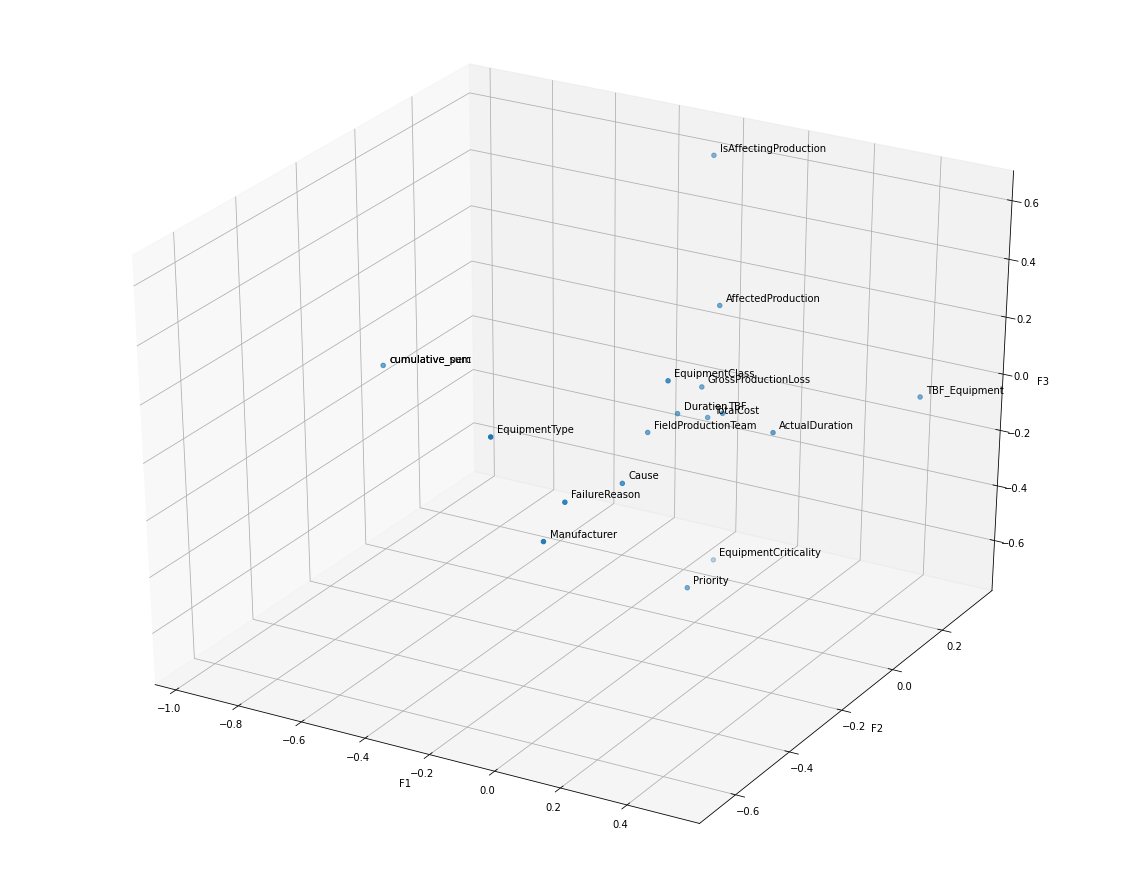

In [ ]:
#Plotting Loadings in 3D

Ldf=pd.DataFrame(L[:,[0,1,2]],columns=["F1","F2","F3"])

fig = plt.figure(figsize=(20,16))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(Ldf["F1"], Ldf["F2"], Ldf["F3"], marker='o')

for row in range(0,len(s)):
    #ax.annotate('X'+str(row+1), (L[row,0]+0.01,L[row,1]+0.01))
    #ax.annotate(header_row[row], (L[row,0]+0.01,L[row,1]+0.01))
    ax.text(L[row,0]+0.01,L[row,1]+0.01,L[row,2]+0.01, header_row[row])

ax.set_xlabel("F1")
ax.set_ylabel("F2")
ax.set_zlabel("F3")

plt.show()

# Machine Learning CatBoost

In [ ]:
df.drop(columns=['WorkOrder', 'Comment', 'EquipmentCode', 'EquipmentRollupCode', 'EquipmentDescription', 'StatusCode', 'StatusDescription', 
                 'StatusShortDescription', 'WOType', 'JobType', 'Action', 'Requirement', 'LaborCost', 'MaterialCost', 'Assigned', 'Trade', 
                 'TradeGroup', 'SupervisorRole', 'Model', 'CreatedBy', 'UpdatedBy', 'CreatedDate', 'UpdatedDate', 'ReportDate', 
                 'ReportMonth', 'ReportWeekDay', 'TargetDate', 'SchEndDate', 'ScheduleCompliant', 'PMOverdue', 'CompletedDate', 
                 'CompletedMonth', 'CompletedWeekDay'], inplace = True)

df = df.fillna(0)

df['Class1'] = np.where(df['Duration'] > 7, df['Duration'], 1)
df['Class0'] = np.where(df['Class1'] <= 7, df['Class1'], 0)
df['Class2'] = np.where(df['TotalCost'] > 6520, df['TotalCost'], 1)
df['Class3'] = np.where(df['Class2'] <= 6520, df['Class2'], 0)
df['Class4'] = np.where(df['TBF_Equipment'] > 40, df['TBF_Equipment'], 1)
df['Class5'] = np.where(df['Class4'] <= 40, df['Class4'], 0)

## Duration

In [ ]:
y_true = df['Class0']
X = df.drop(['TBF', 'Duration', 'Class1', 'Class2', 'Class3', 'Class4', 'Class5'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

cat_features = ['FieldProductionTeam', 'EquipmentType', 'EquipmentClass',
       'EquipmentCriticality', 'Cause', 'FailureReason', 'IsAffectingProduction', 
       'Manufacturer', 'Safety', 'Reopened']

In [ ]:
model = CatBoostClassifier(random_state=1110, eval_metric='F1')

In [ ]:
model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val))

In [ ]:
y_pred = model.predict(X_test)
y_pred

In [ ]:
metrics.f1_score(y_test, y_pred)

In [ ]:
metrics.accuracy_score(y_test, y_pred)

In [ ]:
cm = confusion_matrix(y_test,y_pred)
print(cm)
tn, fp, fn, tp = cm.ravel()

In [ ]:
cm2 = pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted'])
sns.heatmap(cm2,annot=True)

## Total Cost

In [ ]:
y_true = df['Class3']
X = df.drop(['TBF_Equipment', 'TBF', 'GrossProductionLoss', 'AffectedProduction', 'TotalCost', 'Duration', 'ActualDuration', 
             'Class1', 'Class2', 'Class0', 'Class4', 'Class5'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

cat_features = ['FieldProductionTeam', 'EquipmentType', 'EquipmentClass',
       'EquipmentCriticality', 'Cause', 'FailureReason', 'IsAffectingProduction', 
       'Manufacturer', 'Safety', 'Reopened']

In [ ]:
model = CatBoostClassifier(random_state=1110, eval_metric='F1')

In [ ]:
model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val))

In [ ]:
y_pred = model.predict(X_test)
y_pred

In [ ]:
metrics.f1_score(y_test, y_pred)

In [ ]:
metrics.accuracy_score(y_test, y_pred)

In [ ]:
cm = confusion_matrix(y_test,y_pred)
print(cm)
tn, fp, fn, tp = cm.ravel()

In [ ]:
cm2 = pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted'])
sns.heatmap(cm2,annot=True)

## Time between reports

In [ ]:
y_true = df['Class5']
X = df.drop(['TBF_Equipment', 'TBF', 'GrossProductionLoss', 'AffectedProduction', 'TotalCost', 'Duration', 'ActualDuration', 
             'Class1', 'Class2', 'Class0', 'Class4', 'Class3'], axis=1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_true, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25)

cat_features = ['FieldProductionTeam', 'EquipmentType', 'EquipmentClass',
       'EquipmentCriticality', 'Cause', 'FailureReason', 'IsAffectingProduction', 
       'Manufacturer', 'Safety', 'Reopened']

In [ ]:
model = CatBoostClassifier(random_state=1110, eval_metric='F1')

In [ ]:
model.fit(X_train, y_train, cat_features=cat_features, eval_set=(X_val, y_val))

In [ ]:
y_pred = model.predict(X_test)
y_pred

In [ ]:
metrics.f1_score(y_test, y_pred)

In [ ]:
metrics.accuracy_score(y_test, y_pred)

In [ ]:
cm = confusion_matrix(y_test,y_pred)
print(cm)
tn, fp, fn, tp = cm.ravel()

In [ ]:
cm2 = pd.crosstab(y_test,y_pred,rownames=['Actual'],colnames=['Predicted'])
sns.heatmap(cm2,annot=True)

# Conclusion and lessons learned

The machine learning algorthm said in Duration, Total Cost and Time between reports that we have 0 False Negatives and 0 False Positive. So, the threshold in each variable is 1.


*   Duration: The algorithm predicted that everything is above 7 days
*   Total cost: The algorithm predicted that everything is above $6,520.00
*   TBF: The algorithm predicted that everything is above 40 days.

One less

